In [39]:
import numpy as np
import sympy as sy
from copy import copy
import matplotlib.pyplot as plt
from scipy.linalg import eigh
try:  # SciPy >= 0.19
    from scipy.special import comb, logsumexp
except ImportError:
    from scipy.misc import comb, logsumexp  # noqa 

from functools import partial
import mcint
import random
import math
import scipy.integrate as sci
from scipy import stats
from numba import jit
from functools import partial
import vegas
from numpy import linalg as LA
import time 
import threading
import sys
import multiprocessing as multiproc
import datetime
from joblib import Parallel, delayed

In [40]:
def L(x,x_0,eta):
    return 1/np.pi * 1/2*eta /((x-x_0)**2+(eta/2)**2)

In [41]:
## for monte carlo method

def xx(v):
    return np.tan(v)
def dxx(v):
    return 1+np.tan(v)**2
def sub(v,f):
    return f(xx(v))*dxx(v)

def integrate(func,method ='monte_carlo',n=5000):
        if method =='sci':
            result, error = sci.quad(func,-np.inf,np.inf)
        elif method =='sy':
            que =sy.S('q_1')
            expr = func(q)
            result = sy.integrate(expr, (que,-sy.oo,sy.oo))
        elif method =='monte_carlo':
            integ = vegas.Integrator([[-np.pi/2, np.pi/2]])
            evalu = integ(partial(sub,f=func), nitn=10, neval=n)  # estimate the integral
            result , error = evalu[0].mean, evalu[0].sdev
        elif method =='simpson':
            y = func(np.linspace(0,100000,100000))
            result = 2*sci.simpson(y,np.linspace(0,100000,100000 ))
            error =0
        
        return result , error
    
def two_D_integrate(func, method ='sci',n=150):
    if method =='monte_carlo':
            function = lambda s : partial(two_D_sub,f=func)(s[0],s[1])
            integ = vegas.Integrator([[-np.pi/2, np.pi/2],[-np.pi/2, np.pi/2]])
            evalu = integ(function, nitn=10, neval=n)  # estimate the integral
            result , error = evalu.mean, evalu.sdev
    if method =='monte_carlos':
            function = lambda s : func(s[0],s[1])
            integ = vegas.Integrator([[-n/2, n/2],[-n/2, n/2]])
            evalu = integ(function, nitn=10, neval=n*n)  # estimate the integral
            result , error = evalu.mean, evalu.sdev
    if method =='sci':
        result , error = sci.dblquad(func,\
                                     -n,n, -n,n)
    return result


In [42]:
def ew(q, t,w,g,dim=2,Q=0):
    sign = 1
    res_1 = (w*q)**2 /2 + sign*sy.sqrt(g**2*w*q**2 +4*t**2)
    sign = -1
    res_2 = (w*q)**2 /2 + sign*sy.sqrt(g**2*w*q**2 +4*t**2)
    if dim==2:
        return np.array([res_1, res_2])
    elif dim==4:
        res_0 = sy.sqrt(w)*g*Q + (w*q)**2 /2
        res_3 = (w*q)**2 /2
        return np.array([res_0,res_1, res_2, res_3])
    
def ev(q, t,w,g,dim=2):
    t_0,gamma,w_0 = t,g,w
    r = q*gamma*np.sqrt(w_0)/(2*t_0)
    sign = 1
    phi_11 = 1/sy.sqrt(1 + (r + sign* sy.sqrt(r**2 + 1))**2)
    phi_22 = -sign/ sy.sqrt(1 + (r - sign* sy.sqrt(r**2 + 1))**2)
    #res_1 = np.array([phi_11,phi_22])
    sign = -1
    phi_1 = 1/sy.sqrt(1 + (r + sign* sy.sqrt(r**2 + 1))**2)
    phi_2 = -sign/ sy.sqrt(1 + (r - sign* sy.sqrt(r**2 + 1))**2)
    #res_2 = np.array([phi_1,phi_2])
    if dim==2:
        res_1 = np.array([phi_11,phi_22])
        res_2 = np.array([phi_1,phi_2])
        return np.array([res_1, res_2])
    elif dim==4:
        res_1 = np.array([0,phi_11,phi_22,0])
        res_2 = np.array([0,phi_1,phi_2,0])
        a1= np.array([1,0,0,0])
        a2= np.array([0,0,0,1])
        return np.array([a1,res_1, res_2,a2])

In [78]:
def Z( beta:np.float128,\
      t_0:np.float128,w_0:np.float128\
      ,gamma:np.float128,no_factor = False,sector=1)->np.float128:
        if sector==1:
            z_factor = (2*np.pi/beta)**(3/2)*np.exp(beta*(w_0+gamma**2/(2*w_0)))/w_0
            que = sy.symbols('q_1')
            w = ew(que,t_0,w_0,gamma)
            a = sum([sy.exp(-beta*w[n]) for n in range(2)])
            trH = sy.lambdify(que, a) 
            z , z_err = integrate(trH)
            if no_factor:
                return  z , z_err
            else:
                return z_factor* z , z_factor*z_err
        elif sector==0:
            return (2*np.pi/(beta*w_0))**2*np.exp(beta*(w_0))
        elif sector==2:
            return (2*np.pi/(beta*w_0))**2*np.exp(beta*(w_0+gamma**2/(2*w_0)))
        elif sector==3:
            return Z(beta,t_0,w_0,gamma,no_factor = False,sector=0)+\
                    Z(beta,t_0,w_0,gamma,no_factor = False,sector=1)[0]+\
                    Z(beta,t_0,w_0,gamma,no_factor = False,sector=2)
        
        

In [117]:
def spectral_f(w,k,eta:np.float128,beta:np.float128,t_0:np.float128\
               ,w_0:np.float128,gamma:np.float128,zero=0)->np.float128:
    q = sy.symbols('q_1')
    Q = sy.symbols('q_2')
    omega = sy.symbols('omega')
    eigenvector = ev(q, t_0,w_0,gamma,dim=4)
    eigenvalue = ew(q,t_0,w_0,gamma,dim=4,Q=Q)
    c_0 = np.array([[0, 0, 1, 0],
                    [0, 0, 0, 1],
                    [0, 0, 0, 0],
                    [0, 0, 0, 0]])
    c_1 = np.array([[0, 1, 0, 0],
                    [0, 0, 0, 0],
                    [0, 0, 0,-1],
                    [0, 0, 0, 0]])
    c_0_plus = np.array([[0, 0, 0, 0],
                         [0, 0, 0, 0],
                         [1, 0, 0, 0],
                         [0, 1, 0, 0]])
    c_1_plus = np.array([[0, 0, 0, 0],
                         [1, 0, 0, 0],
                         [0, 0, 0, 0],
                         [0, 0,-1, 0]])
    c_k1 = (c_0+c_1)/np.sqrt(2)
    c_k2 = (c_0-c_1)/np.sqrt(2) # wo vorzeichen?
    c_k1_plus = (c_0_plus+c_1_plus)/np.sqrt(2)
    c_k2_plus = (c_0_plus-c_1_plus)/np.sqrt(2)
    if k==1:
        c=c_k1
    elif k==2:
        c=c_k2
    spectral_k = 0 
    z = Z( beta,t_0,w_0,gamma,no_factor = False,sector=3)
    if zero==0:
        for n in range(4):
            for m in range(4):
                spectral_k += (sy.exp(-beta*eigenvalue[n])+sy.exp(-beta*eigenvalue[m]))*\
                           np.absolute(eigenvector[m]@c@eigenvector[n])**2*L(omega,eigenvalue[n]-eigenvalue[m],eta)
    else:
        eigenvalue[0]=0
        m=0
        for n in range(4):
            spectral_k += (sy.exp(-beta*eigenvalue[n])+sy.exp(-beta*eigenvalue[m]))*\
                           np.absolute(eigenvector[m]@c@eigenvector[n])**2*L(omega,eigenvalue[n]-eigenvalue[m],eta)
    prefactor = 1/(gamma*np.sqrt(w_0))*((2*np.pi)**2/beta)*np.exp(beta*w_0)
    H_Q = sy.exp(-beta*(w_0**2/2*Q**2 -gamma*np.sqrt(w_0)*Q))
    #result = []
    #for ww in w:
        #func_ = sy.lambdify([q, Q], (spectral_k*sy.exp(-beta*w_0**2/2*(Q-gamma/w_0**(3/2))**2)).subs({omega:ww}))
    #    func_ = sy.lambdify([q, Q], (spectral_k*H_Q).subs({omega:ww}))
    #    res = two_D_integrate(func_, method ='sci',n=130)
    #    result.append(np.exp(beta*gamma**2/(2*w_0))*prefactor*res/z)
    spec = Parallel(n_jobs=11)(delayed(two_D_integrate)\
                              (partial(sy.lambdify([q, Q,omega],(spectral_k*H_Q)),omega=ww))
                              for ww in w)

    return np.array(spec)*prefactor/z

In [45]:
params = [(1,.1,1),(1,.3,1),(1,1,2),(1,.5,2)]
eta = 0.1
T = [0.1,.5,1,2]
w = np.linspace(-10,10,100)

In [118]:



t_0,w_0,gamma = 1,1,1
spectral0 = spectral_f(w,1,eta,1,t_0,w_0,gamma,zero=1) 
spectral1 = spectral_f(w,2,eta,1,t_0,w_0,gamma,zero=1) 
    


/usr/lib64/python3.10/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib64/python3.10/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain fr

In [61]:
#np.save('spectral0',spectral0)
#np.save('spectral1',spectral1)

In [53]:
lines = ['dashdot','dashed','dotted'] # 'solid'


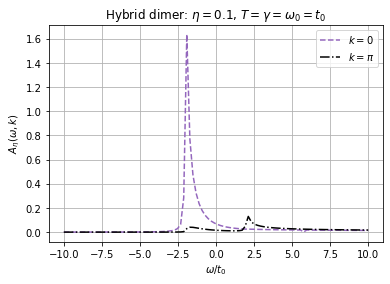

In [119]:
plt.plot(w,np.array(spectral0)/2/np.pi, label=r'$k=0$', color ='tab:purple',linestyle=lines[1])
plt.plot(w,spectral1/2/np.pi, label=r'$k=\pi$', color ='black',linestyle=lines[0])
plt.grid()
plt.title(r'Hybrid dimer: $\eta=0.1$, $T=\gamma=\omega_0=t_0$')
plt.xlabel(r'$\omega/t_0$')
plt.ylabel(r'$A_\eta(\omega,k)$')
plt.legend()
#plt.savefig("hybrid-dimer.pdf")

In [49]:
print(sum(spectraal1[0])*(W[1]-W[0]))
print(sum(spectraal0[0])*(W[1]-W[0]))
for x in range(1,len(spectraal1)):
    print((sum(spectraal1[x])*(w[1]-w[0]))/2/np.pi)
    print((sum(spectraal0[x])*(w[1]-w[0]))/2/np.pi)

6.46112716608878
6.461027681746011
0.19455557204857057
0.20444740602639577
0.17969569203771163
0.20285202122919693
0.9603058766357119
1.0216401192953362


In [46]:
sss0 = []
sss1 = []
t_0,w_0,gamma = 1,1,1
T = [.5,1,2]
for temp in T:
    print(temp)
    sss0.append(spectral_f(w,1,eta,1/temp,t_0,w_0,gamma))
    sss1.append(spectral_f(w,2,eta,1/temp,t_0,w_0,gamma))

0.5


/usr/lib64/python3.10/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib64/python3.10/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib64/python3.10/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib64/python3.10/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib64/python3.10/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The integral is pro

1


/usr/lib64/python3.10/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


2


/usr/lib64/python3.10/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/usr/lib64/python3.10/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain fr

In [47]:
np.save('Sp0hy',sss0)
np.save('Sp1hy',sss1)

In [54]:
#np.save('Sp0hy',sss0)
#np.save('Sp1hy',sss1)
sp1 = np.load("sp1.npy")
sp0 = np.load("sp0.npy")

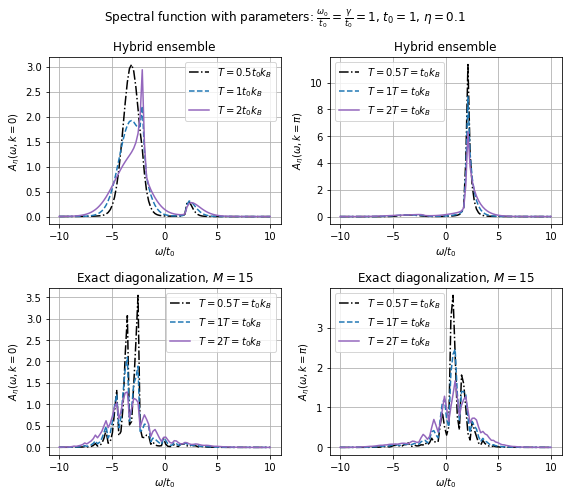

In [55]:
lines = ['dashdot','dashed','solid','dotted'] # 'solid'
hystle = 'solid'
color = ['black','tab:blue','tab:purple','darkseagreen','tab:red']
fig, axs = plt.subplots(2, 2, figsize=(8,7),sharex=False, sharey=False)
fig.suptitle("Spectral function with parameters: "r'$\frac{\omega_0}{t_0}=\frac{\gamma}{t_0}=1$, $t_0=1$, $\eta=0.1$', fontsize = 12.)
for n in range(3): 
    axs[0,0].plot(w,sss0[n],color=color[n],label =r'$T=$'+str(T[n])+r'$t_0k_B$',linestyle=lines[n])
    axs[0,1].plot(w,sss1[n],color=color[n],label =r'$T=$'+str(T[n])+r'$T=t_0k_B$',linestyle=lines[n])
    axs[1,0].plot(w,sp0[n],color=color[n],label =r'$T=$'+str(T[n])+r'$T=t_0k_B$',linestyle=lines[n])
    axs[1,1].plot(w,sp1[n],color=color[n],label =r'$T=$'+str(T[n])+r'$T=t_0k_B$',linestyle=lines[n])
axs[0,0].set_title("Hybrid ensemble")
axs[0,1].set_title("Hybrid ensemble")
axs[1,0].set_title("Exact diagonalization, "+ r'$M=15$')
axs[1,1].set_title("Exact diagonalization, "+ r'$M=15$')

axs[0,0].set_ylabel(ylabel=r'$A_\eta(\omega,k=0)$')
axs[0,1].set_ylabel(ylabel=r'$A_\eta(\omega,k=\pi)$')
axs[1,0].set_ylabel(ylabel=r'$A_\eta(\omega,k=0)$')
axs[1,1].set_ylabel(ylabel=r'$A_\eta(\omega,k=\pi)$')

for (x,y) in axs:
    x.set_xlabel(xlabel=r'$\omega/t_0$')
    y.set_xlabel(xlabel=r'$\omega/t_0$')
for ax in fig.get_axes():
    #ax.label_outer()
    ax.grid()
    ax.legend()
fig.tight_layout()
plt.savefig("spectral.pdf")

In [34]:
def testZ(beta,t_0,w_0,gamma,n = 120):
    q = sy.symbols('q_1')
    Q = sy.symbols('q_2')
    #### ew
    eigenvalue1 = (w_0*q)**2 /2 + sy.sqrt(gamma**2*w_0*q**2 +4*t_0**2)
    eigenvalue2 = (w_0*q)**2 /2 -sy.sqrt(gamma**2*w_0*q**2 +4*t_0**2)
    eigenvalue0 = np.sqrt(w_0)*gamma*Q + (w_0*q)**2 /2
    eigenvalue3 = (w_0*q)**2 /2
    #####
    HQ = sy.exp(-beta*(w_0**2/2* Q**2 -gamma*np.sqrt(w_0)*Q))
    a1 = sy.exp(-beta*eigenvalue1)
    a2 = sy.exp(-beta*eigenvalue2)
    a0 = sy.exp(-beta*eigenvalue0)
    a3 = sy.exp(-beta*eigenvalue3)
    #a0 = sy.exp(-beta*w_0**2/2 *(q**2+Q**2))
    #a1 = np.exp(beta*gamma**2/(2*w_0))*sy.exp(-beta*w_0**2/2 *(q**2+(Q-gamma/w_0**(3/2))**2)) *\
    #                   sy.exp(beta*sy.sqrt(gamma**2*w_0*q**2 +4*t_0**2)) 
    #a2 = np.exp(beta*gamma**2/(2*w_0))*sy.exp(-beta*w_0**2/2 *(q**2+(Q-gamma/w_0**(3/2))**2)) *\
    #                   sy.exp(-beta*sy.sqrt(gamma**2*w_0*q**2 +4*t_0**2))
    #a3 = np.exp(beta*gamma**2/(2*w_0))*sy.exp(-beta*w_0**2/2 *(q**2+(Q-gamma/w_0**(3/2))**2))
    a = a0+a1+a2+a3
                       
    #eigenvalue = ew(q,t_0,w_0,gamma,dim=4,Q=Q)
    #HQ = sy.exp(-beta*w_0**2/2*(Q-gamma/w_0**(3/2))**2)*np.exp(beta*gamma**2/(2*w_0))
    #a = sum([sy.exp(-beta*eigenvalue[n]) for n in range(4)])
    trH = sy.lambdify([q, Q], a*HQ)
    z = two_D_integrate(trH, method ='sci',n=n)
    return np.pi*2*z/beta*np.exp(beta*w_0)

In [60]:
N = [100+25*n for n in range(25)]
beta,t_0,w_0,gamma = .2,1,1,1
ZqQ = []
Zq = Z(beta,t_0,w_0,gamma,no_factor = False,sector=3)
for n in N:
    ZqQ.append(testZ(beta,t_0,w_0,gamma,n = n))
    

In [76]:
r = np.linspace(100,900)
Zq = Z(beta,t_0,w_0,gamma,no_factor = False,sector=3)

In [81]:
np.array(ZqQ)- Zq[0]

array([0.05650476, 0.05650476, 0.05650476, 0.05650476, 0.05650477,
       0.05650477, 0.05650477, 0.05650477, 0.05650476, 0.05650475,
       0.05650476, 0.05650474, 0.05650475, 0.05650475, 0.05650474,
       0.05650475, 0.05650475, 0.05650476, 0.05650476, 0.05650477,
       0.05650477, 0.05650478, 0.05650479, 0.05650479, 0.05650478])

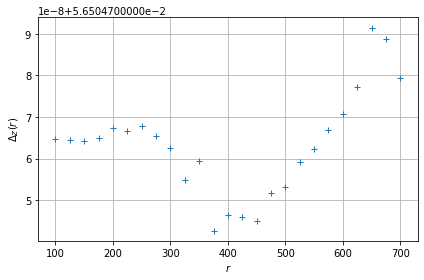

In [97]:
plt.plot(N,np.array(ZqQ)- Zq[0],'+')
plt.xlabel('$r$')
plt.ylabel('$\Delta_Z(r)$')
plt.grid()
plt.tight_layout()
plt.savefig("Delta_Z.pdf")

In [112]:
for n in range(len(sss0)):
    print("int A(0) dw = ", sum(sss0[n]/2/np.pi)*(w[1]-w[0]))
    print("int A(1) dw = ", sum(sss1[n]/2/np.pi)*(w[1]-w[0]))
    print("int A(0)w dw = ", sum(np.array(sss0[n])/np.pi/2*w)*(w[1]-w[0]))
    print("int A(1)w dw = ", sum(np.array(sss1[n])/np.pi/2*w)*(w[1]-w[0]))

int A(0) dw =  0.9947317032890545
int A(1) dw =  0.898354406662202
int A(0)w dw =  -2.9197402063447315
int A(1)w dw =  1.7537182313475919
int A(0) dw =  0.9872304728673675
int A(1) dw =  0.9279502628893588
int A(0)w dw =  -2.759631132737826
int A(1)w dw =  1.7898508784805813
int A(0) dw =  0.9801355362946536
int A(1) dw =  0.9523858695027265
int A(0)w dw =  -2.51838194655753
int A(1)w dw =  1.791428303872743


In [108]:
print("int A(1) dw = ", sum(np.array(sss0[n])/np.pi/2*w)*(w[1]-w[0]))

int A(1) dw =  -2.51838194655753


In [124]:
np.exp(111111)

/tmp/ipykernel_24155/1425925561.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(111111)


inf